<a href="https://colab.research.google.com/github/Nazneen-akram/NED-Data-Science-Artificial-Intelligence/blob/main/Cats_vs_Dogs_FlowfromDataframe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Keras Cats vs Dogs - Training using your own data**

---

In this notebook, we learn how to setup data generators to load our own dataset and train a classifier using Keras.
1. Download and Explore our data
2. Create a simple CNN
3. Create our Data Generators
4. Train our model
5. Test some inferences
6. Checkpoints

In [1]:
# import our packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

## **1. Download and Explore our Data**

In [2]:
!gdown --id 1Dvw0UpvItjig0JbnzbTgYKB-ibMrXdxk
!unzip -q dogs-vs-cats.zip
!unzip -q train.zip
!unzip -q test1.zip

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1Dvw0UpvItjig0JbnzbTgYKB-ibMrXdxk
To: /content/dogs-vs-cats.zip
100% 852M/852M [00:08<00:00, 97.7MB/s]


In [3]:
# Define our images sizes
IMAGE_WIDTH = 60
IMAGE_HEIGHT = 60
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3

### **Loading our data and it's labels into a dataframe**

There are many ways we can do this, this way is relatively simple to follow.

`dog.1034234.jpg`

In [4]:
filenames = os.listdir("./train")

categories = []

for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'class': categories
})
df.head()

,filename,class
0,cat.9291.jpg,0
1,cat.803.jpg,0
2,dog.11916.jpg,1
3,dog.10296.jpg,1
4,dog.9817.jpg,1


### **Check the counts in each class**

<Axes: >

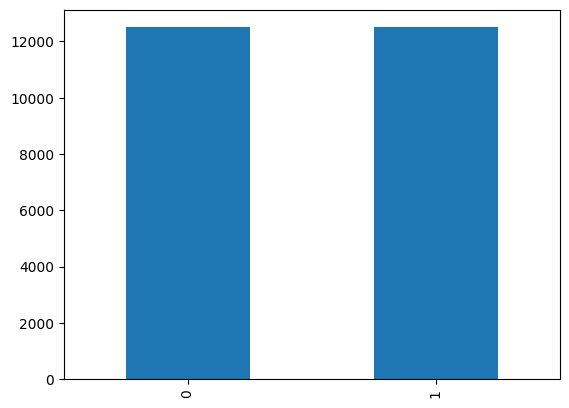

In [5]:
df['class'].value_counts().plot.bar()

#### **View a sample image**

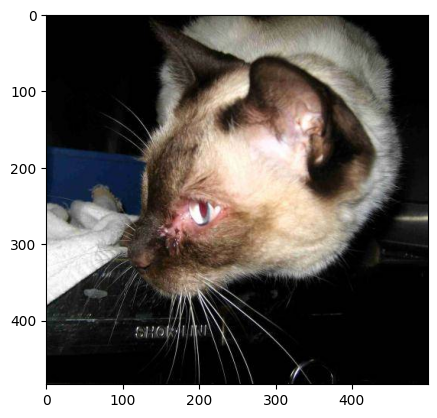

In [6]:
sample = random.choice(filenames)
image = load_img("./train/" + sample)
plt.imshow(image)

## **2. Create our Model**

In [7]:
from keras.models import Sequential
from tensorflow import keras
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation

model = Sequential()

model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

opt = keras.optimizers.Adam(learning_rate=0.0005)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 58, 58, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 29, 29, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 13, 13, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 5, 5, 64)          0

## **3. Create our Data Generators**

In [8]:
df["class"] = df["class"].replace({0: 'cat', 1: 'dog'})
df.head()

,filename,class
0,cat.9291.jpg,cat
1,cat.803.jpg,cat
2,dog.11916.jpg,dog
3,dog.10296.jpg,dog
4,dog.9817.jpg,dog


#### **Split our dataset using train_test_split**

In [9]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=7)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [10]:
train_df.head()

,filename,class
0,dog.8942.jpg,dog
1,cat.10484.jpg,cat
2,cat.2289.jpg,cat
3,cat.4184.jpg,cat
4,cat.2248.jpg,cat


In [11]:
validate_df.head()

,filename,class
0,dog.11540.jpg,dog
1,dog.603.jpg,dog
2,cat.2428.jpg,cat
3,cat.9149.jpg,cat
4,dog.3900.jpg,dog


### **Create our Training Data Generator**

In [12]:
batch_size = 32

train_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    "./train/",
    x_col = 'filename',
    y_col = 'class',
    target_size = IMAGE_SIZE,
    class_mode = 'categorical',
    batch_size = batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


### **Create our Validation Data Generator**

In [13]:
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    "./train/",
    x_col='filename',
    y_col='class',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


#### **Creating an example Data Generator to load just a single image**

In [14]:
example_df = train_df.sample(n=1).reset_index(drop=True)

example_generator = train_datagen.flow_from_dataframe(
    example_df,
    "./train/",
    x_col='filename',
    y_col='class',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


#### **Preview that image**

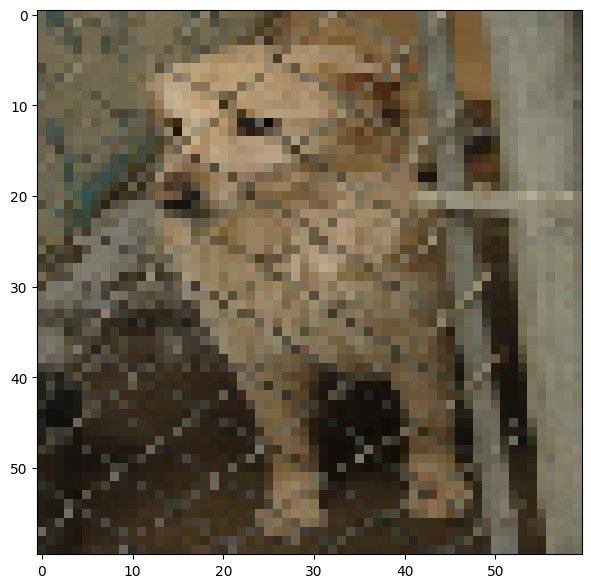

In [15]:
plt.figure(figsize=(6, 6))

for X_batch, Y_batch in example_generator:
    image = X_batch[0]
    plt.imshow(image)
    break

plt.tight_layout()
plt.show()

## **4. Start Training Our Model**

In [16]:
epochs = 10

history = model.fit(
    train_generator,
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps = 5000//batch_size,
    steps_per_epoch = 20000//batch_size,
)

Epoch 1/10
625/625 [==============================] - 48s 61ms/step - loss: 0.6342 - accuracy: 0.6264 - val_loss: 0.5598 - val_accuracy: 0.7101
Epoch 2/10
625/625 [==============================] - 34s 54ms/step - loss: 0.5173 - accuracy: 0.7454 - val_loss: 0.4853 - val_accuracy: 0.7564
Epoch 3/10
625/625 [==============================] - 39s 63ms/step - loss: 0.4512 - accuracy: 0.7873 - val_loss: 0.4318 - val_accuracy: 0.8063
Epoch 4/10
625/625 [==============================] - 33s 53ms/step - loss: 0.4021 - accuracy: 0.8163 - val_loss: 0.4238 - val_accuracy: 0.8045
Epoch 5/10
625/625 [==============================] - 37s 60ms/step - loss: 0.3559 - accuracy: 0.8430 - val_loss: 0.4171 - val_accuracy: 0.8103
Epoch 6/10
625/625 [==============================] - 37s 59ms/step - loss: 0.3014 - accuracy: 0.8695 - val_loss: 0.4263 - val_accuracy: 0.8143
Epoch 7/10
625/625 [==============================] - 38s 60ms/step - loss: 0.2543 - accuracy: 0.8927 - val_loss: 0.4340 - val_accuracy:

In [17]:
# Save our model
model.save_weights("cats_vs_dogs_10_epochs.h5")

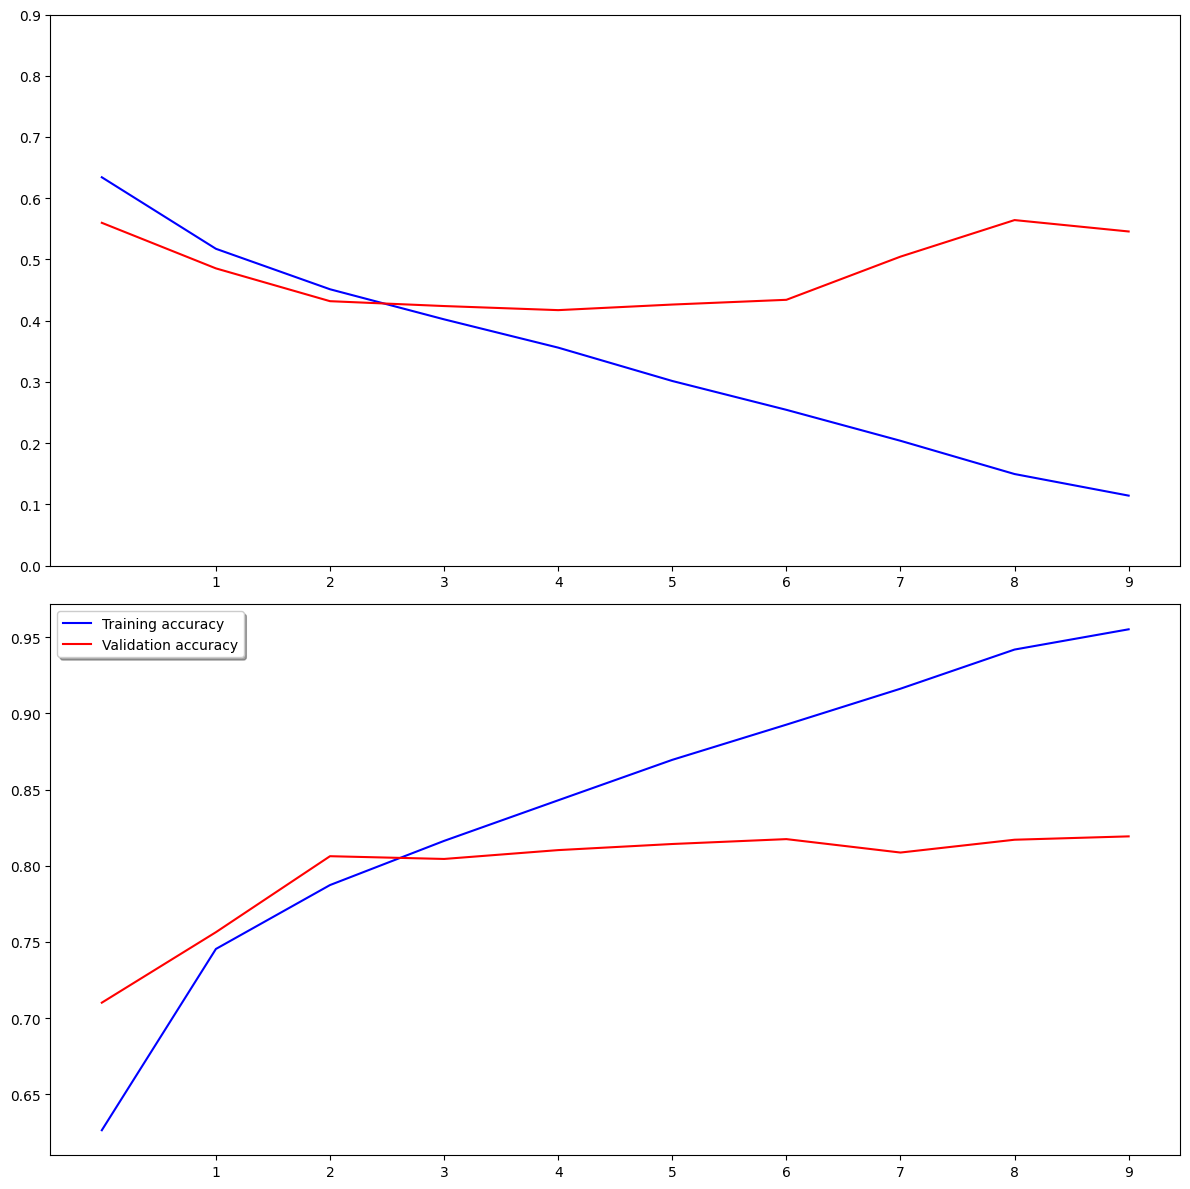

In [18]:
# Viewour for performance plots

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

#### **Get the predictions for our validation images**

In [19]:
# We run our prediction on all images in the validation set
predict = model.predict_generator(validation_generator, steps = np.ceil(5000/batch_size))

<ipython-input-19-a1e479a38781>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = model.predict_generator(validation_generator, steps = np.ceil(5000/batch_size))


#### **Add it to our dataframe for eacy viewing**

In [20]:
validate_df['predicted'] = np.argmax(predict, axis=-1)
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
validate_df['predicted'] = validate_df['predicted'].replace(label_map)
validate_df

,filename,class,predicted
0,dog.11540.jpg,dog,cat
1,dog.603.jpg,dog,dog
2,cat.2428.jpg,cat,cat
3,cat.9149.jpg,cat,cat
4,dog.3900.jpg,dog,dog
...,...,...,...
4995,dog.88.jpg,dog,dog
4996,cat.10753.jpg,cat,cat
4997,cat.7858.jpg,cat,dog
4998,dog.7306.jpg,dog,dog


## **Inference on a batch of images from our validation dataset**

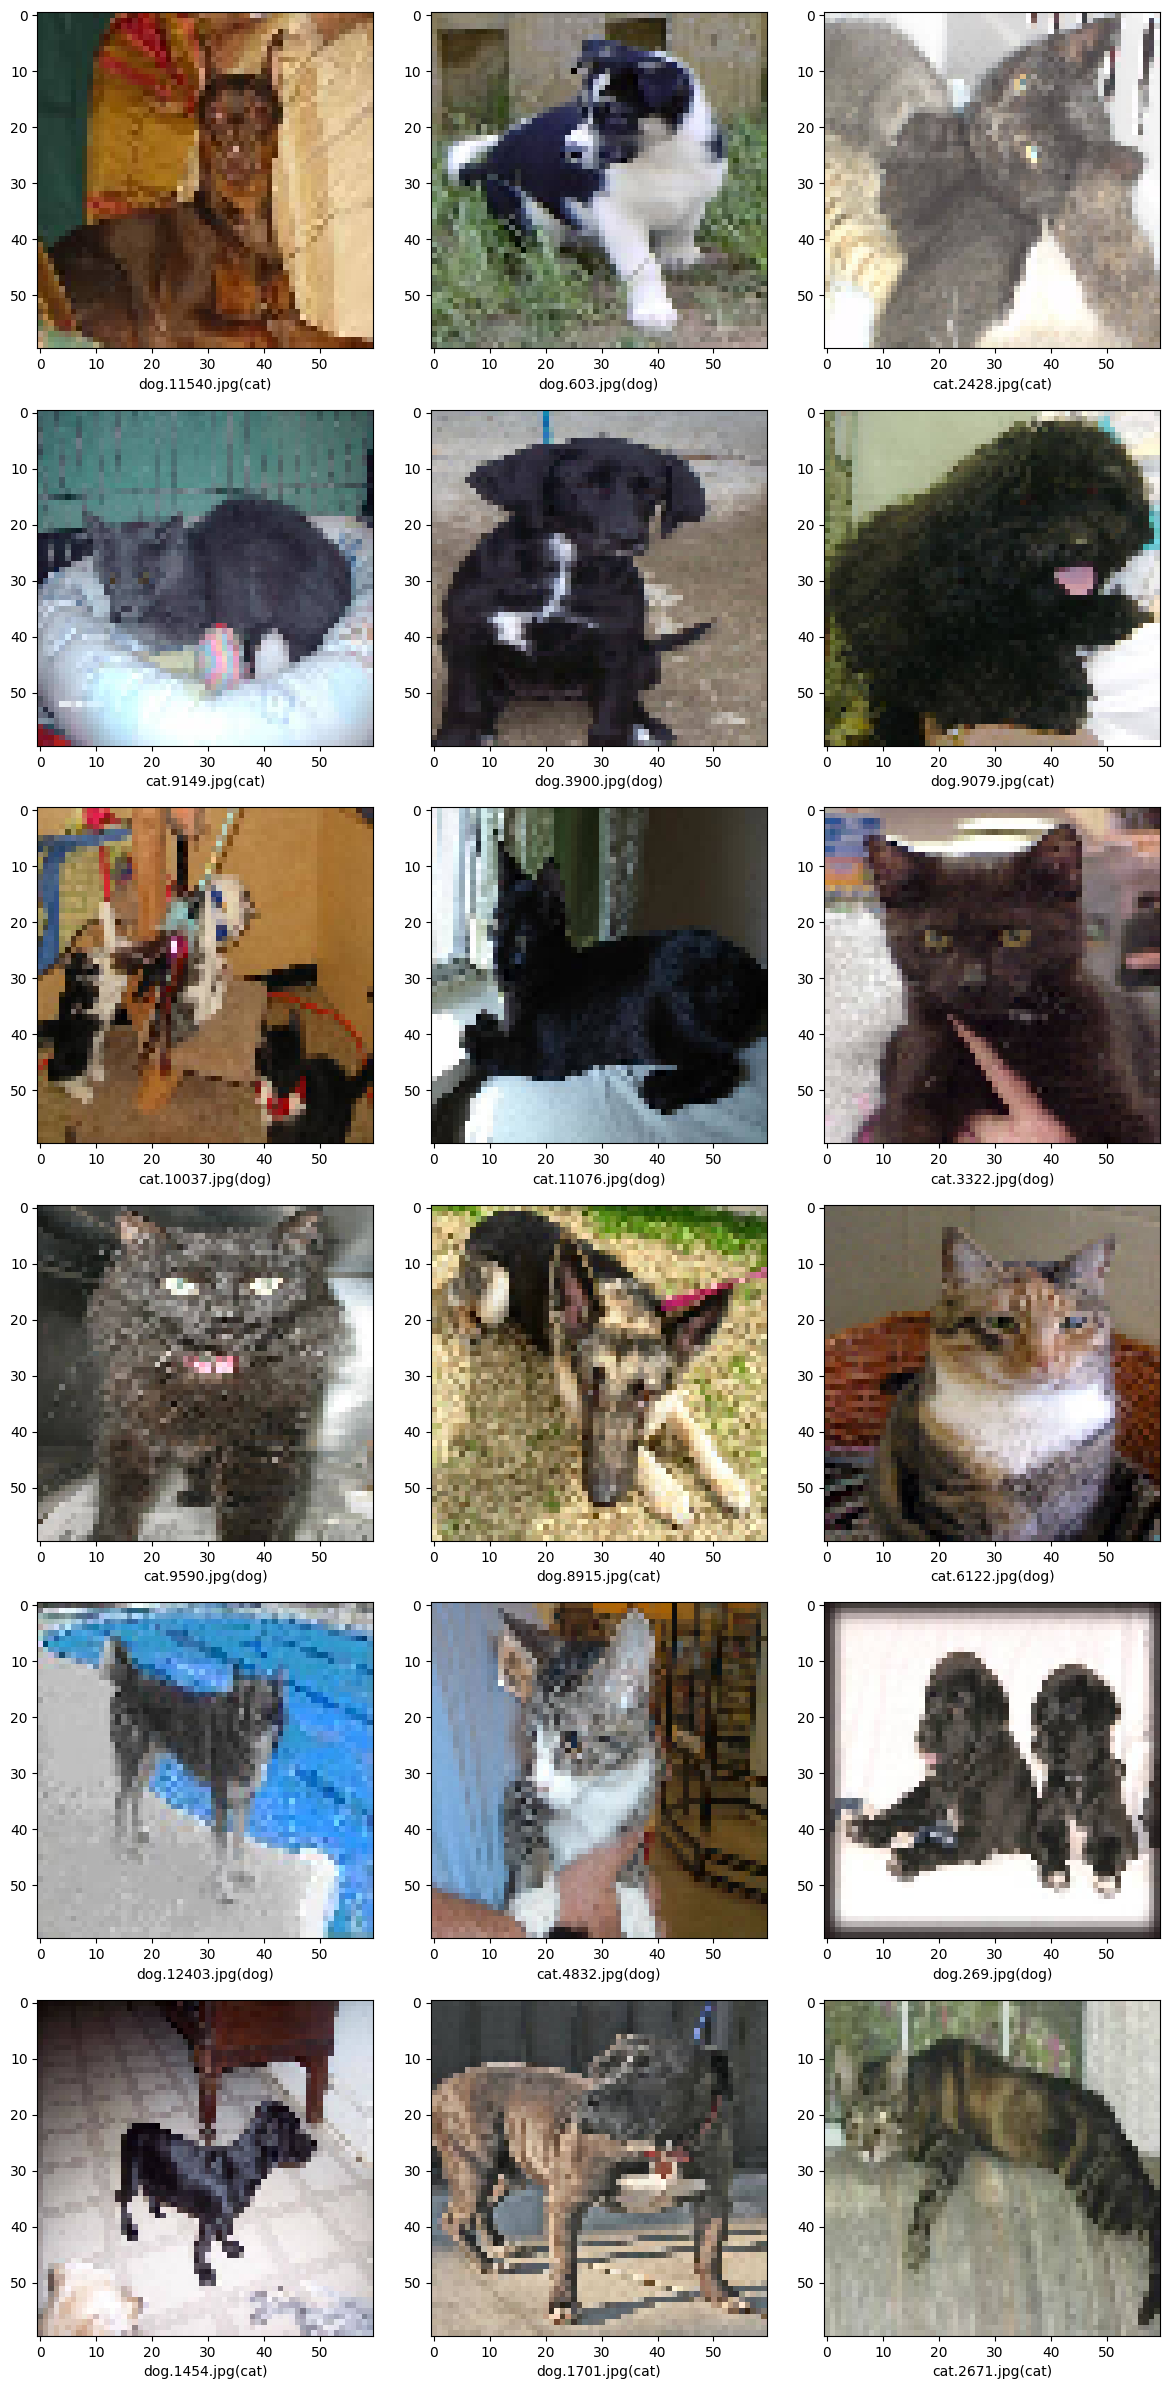

In [21]:
sample_test = validate_df.head(18)
sample_test.head()

plt.figure(figsize=(12, 24))

for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['predicted']
    img = load_img("./train/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )

plt.tight_layout()
plt.show()

In [22]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [23]:
checkpoint = ModelCheckpoint("MNIST_Checkpoint.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', # value being monitored for improvement
                          min_delta = 0, #Abs value and is the min change required before we stop
                          patience = 5, #Number of epochs we wait before stopping
                          verbose = 1,
                          restore_best_weights = True) #keeps the best weigths once stopped

### **Another useful callback is Reducing our learning Rate on Plateau**

We can avoid having our oscillate around the global minimum by attempting to reduce the Learn Rate by a certain fact. If no improvement is seen in our monitored metric (val_loss typically), we wait a certain number of epochs (patience) then this callback reduces the learning rate by a factor

In [24]:
from keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 3, verbose = 1, min_delta = 0.0001)

In [25]:
# we put our call backs into a callback list
callbacks = [earlystop, checkpoint, reduce_lr]

In [ ]:
epochs = 10

history = model.fit(
    train_generator,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = 5000//batch_size,
    steps_per_epoch = 20000//batch_size,
)

Epoch 1/10
625/625 [==============================] - ETA: 0s - loss: 0.0868 - accuracy: 0.9674
Epoch 1: val_loss improved from inf to 0.64298, saving model to MNIST_Checkpoint.h5
625/625 [==============================] - 37s 59ms/step - loss: 0.0868 - accuracy: 0.9674 - val_loss: 0.6430 - val_accuracy: 0.8261 - lr: 5.0000e-04
Epoch 2/10
  3/625 [..............................] - ETA: 24s - loss: 0.0671 - accuracy: 0.9792

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - ETA: 0s - loss: 0.0704 - accuracy: 0.9740
Epoch 2: val_loss improved from 0.64298 to 0.61217, saving model to MNIST_Checkpoint.h5
625/625 [==============================] - 38s 61ms/step - loss: 0.0704 - accuracy: 0.9740 - val_loss: 0.6122 - val_accuracy: 0.8185 - lr: 5.0000e-04
Epoch 3/10
624/625 [============================>.] - ETA: 0s - loss: 0.0599 - accuracy: 0.9775
Epoch 3: val_loss did not improve from 0.61217
625/625 [==============================] - 38s 60ms/step - loss: 0.0599 - accuracy: 0.9775 - val_loss: 0.6952 - val_accuracy: 0.8245 - lr: 5.0000e-04
Epoch 4/10
624/625 [============================>.] - ETA: 0s - loss: 0.0475 - accuracy: 0.9839
Epoch 4: val_loss did not improve from 0.61217
625/625 [==============================] - 39s 62ms/step - loss: 0.0475 - accuracy: 0.9839 - val_loss: 0.7162 - val_accuracy: 0.8101 - lr: 5.0000e-04
Epoch 5/10
270/625 [===========>..................] - ETA: 15s - loss: 0.0274 - accuracy: 0